In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize,BoundaryNorm
from numba import njit
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from scipy.sparse import csr_matrix
import time 

# Class Parameters:
#### N: sets the population size at N*N 
#### duration: sets the time for the simulation (in days)
#### r_0: sets the initial population infection
#### infection_rate: sets the average chance for infection at encounter
#### mortality_rate: sets the chance for the individual to expire at when infected
#### sociability: sets the social-sphere of each person. A value of 1 is every adjecent individual, a value of 2 extends this perimeter by 1 and so on
#### transmission_time: sets the amount of time an individual can transmit the disease after infection
####  imunity_time: sets the amount of time of an individual is imune after recovery

In [18]:
class population():
    def __init__(self,N = 100,duration = 100,transmission_time = 7,imunity_time = 7,r_0 = 0.01,infection_rate = 0.3,mortality_rate = 0.03,sociability = 3):
        self.N = N
        self.duration = duration
        self.transmission_time = transmission_time
        self.imunity_time = imunity_time
        self.sociability = sociability
        self.mortality_rate = mortality_rate
        self.r_0 = r_0
        self.infection_rate = infection_rate
        self.history = []
        self.per = []
        self.death = []
        self.world = np.zeros((N, N), dtype=[('health', 'float16'), ('status', 'uint8'), ('timer', 'int32')])
        self.world['health'] = np.random.uniform(0.5, 1, (N, N))
        self.world['timer'] = -imunity_time
        for _ in range(round(r_0*N**2)):
            i,j = np.random.randint(N),np.random.randint(N)
            self.world['status'][i,j] = 1   # set status
            self.world['timer'][i,j] = self.transmission_time # set time to transmit disease
        # the world is created through a two dimensional structered array with the three fields healt,status,timer
    def sim(self):
        %matplotlib notebook
        t = 0
        dt = 1
        while t < self.duration:
            infected_indices = np.where(self.world['status'] == 1)
            for x,y in zip(*infected_indices):
                start_y = max(y - self.sociability, 0)
                end_y = min(y + self.sociability + 1, self.world.shape[0])
                start_x = max(x - self.sociability, 0)
                end_x = min(x + self.sociability + 1, self.world.shape[1])
                sub_world = self.world[start_y:end_y, start_x:end_x]
                health_matrix, status_matrix, recovery_matrix = sub_world['health'], sub_world['status'], sub_world['timer']  # Get the recovery time sub-matrix
                susceptible_condition = (status_matrix == 0) & (recovery_matrix < -self.imunity_time)
                if not np.any(susceptible_condition):
                    continue
                infection_chance = health_matrix - np.random.uniform(0, 0.5, health_matrix.shape).astype(np.float16)  # Apply the random transmission factor
                new_infections = np.where((infection_chance < self.infection_rate) & susceptible_condition)  # Find the new infections
                new_diseased = np.where((infection_chance < self.infection_rate*self.mortality_rate) & susceptible_condition)  # Find the disease  
                if not np.any(new_infections):
                    continue
                status_matrix[new_infections[0], new_infections[1]] = 1  # Infect the new infections
                recovery_matrix[new_infections[0], new_infections[1]] = self.transmission_time  # Set the recovery time of the new infections
                status_matrix[new_diseased[0], new_diseased[1]] = 2
                self.world['status'][start_y:end_y, start_x:end_x] = status_matrix
                self.world['timer'][start_y:end_y, start_x:end_x] = recovery_matrix                      
            self.world['timer'] -= 1
            self.world['status'][(self.world['status'] == 1) & (self.world['timer'] < 0)] = 0
            self.history.append(csr_matrix(self.world['status']))
            death_tally = np.sum(self.world['status'] == 2)
            self.per.append(np.sum(self.world['status'] == 1) / (self.N*self.N - death_tally) * 100)
            self.death.append(death_tally/(self.N*self.N) * 100)
            t += dt
        cmap = ListedColormap(['white', 'red', 'black'])
        norm = BoundaryNorm([0, 1, 2, 3], cmap.N) 
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1, 1]})
        gs = GridSpec(1, 3, width_ratios=[8, 1, 1])
        ax1,ax2,ax3 = plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])
        plot = ax1.imshow(self.history[0].toarray(), cmap=cmap, norm=norm)
        time_text = ax1.text(0.4,  1.05, '', transform=ax1.transAxes, color='black')
        for ax in (ax1,ax2,ax3):
            ax.set_xticks([])
            ax.set_yticks([])
        infected_bar = ax2.bar(0, 0, color='red')
        diseased_bar = ax3.bar(0, 0, color='black')
        ax2.set_ylim(0, 100), ax3.set_ylim(0, 100)
        ax2.set_title('Infected (%)',fontsize=7), ax3.set_title('Diseased (%)',fontsize=7)
        def animate(i):
            plot.set_data(self.history[i].toarray())
            time_text.set_text('Day:  %.1f' % i )
            bar_inf = infected_bar[0]
            bar_dis = diseased_bar[0]
            bar_inf.set_height(self.per[i])
            bar_dis.set_height(self.death[i])
            return plot, time_text, bar_inf,bar_dis
        animation = FuncAnimation(fig,
                              func = animate,
                              frames = np.arange(len(self.history)), 
                              interval = 150)
        return animation

<IPython.core.display.Javascript object>


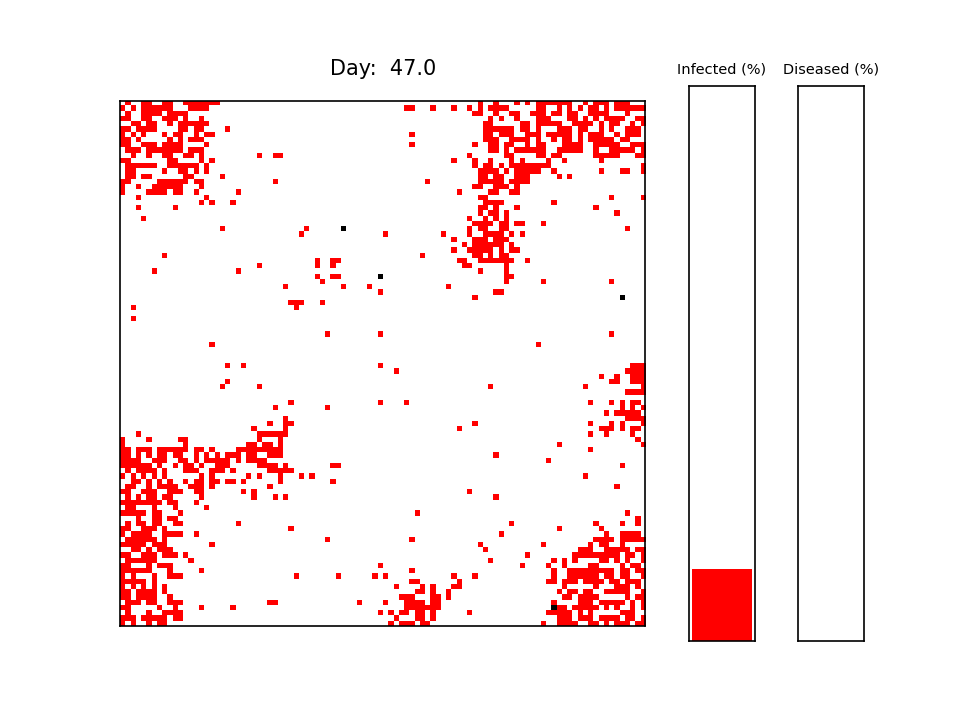

Time taken to run the simulation:  10.316107511520386 seconds


In [17]:

test = population(N = 100, duration = 100, r_0 = 0.01, infection_rate = 0.3, transmission_time=7, 
                  imunity_time=7, sociability = 3, mortality_rate = 0.03)
start_time = time.time()
history = test.sim()
end_time = time.time()

print("Time taken to run the simulation: ", end_time - start_time, "seconds")